# Demo of Recurrent Neural Networks

In [38]:
# Standard Math / Data libraries
import numpy as np
import pandas as pd

# Data Scrape Package
import pandas_datareader.data as web

# Plotting package
import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, Sequential  # Import Sequential and layers from Keras

import yfinance as yf

# Set Random seed
import random
random.seed(2584)


# Cleaning the Data 

In [39]:
# Download daily crude oil price data from Yahoo Finance
crude_oil = yf.download(tickers='CL=F', start='2015-12-20', end='2024-04-22', interval='1d')

# Explore the data
print(crude_oil.tail())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2024-04-15  85.930000  86.110001  84.050003  85.410004  85.410004  343894
2024-04-16  85.699997  86.180000  84.750000  85.360001  85.360001  241343
2024-04-17  85.360001  85.510002  82.550003  82.690002  82.690002  259540
2024-04-18  82.790001  83.470001  81.559998  82.730003  82.730003   84468
2024-04-19  82.620003  86.279999  81.800003  83.139999  83.139999   76901


In [40]:
crude_oil

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-21,34.580002,34.860001,33.980000,34.740002,34.740002,298080
2015-12-22,35.799999,36.540001,35.660000,36.139999,36.139999,302263
2015-12-23,36.470001,37.950001,36.279999,37.500000,37.500000,374658
2015-12-24,37.860001,38.279999,37.380001,38.099998,38.099998,205873
2015-12-28,38.000000,38.090000,36.599998,36.810001,36.810001,220644
...,...,...,...,...,...,...
2024-04-15,85.930000,86.110001,84.050003,85.410004,85.410004,343894
2024-04-16,85.699997,86.180000,84.750000,85.360001,85.360001,241343
2024-04-17,85.360001,85.510002,82.550003,82.690002,82.690002,259540


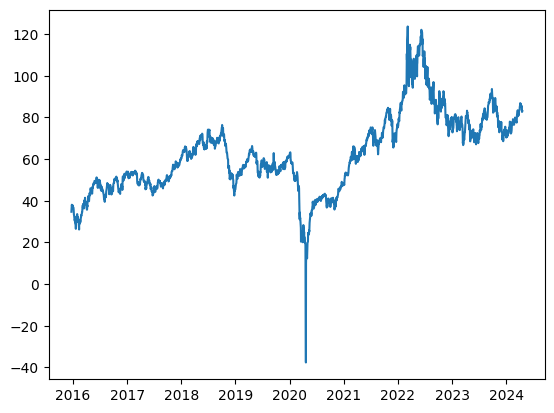

In [41]:
plt.plot(crude_oil['Adj Close'])

In [43]:
returns = crude_oil['Adj Close'].pct_change() 

column_names = crude_oil.columns
x = crude_oil.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [44]:
pct_c_crude_oil = df

In [45]:
pct_c_crude_oil.columns = column_names

In [46]:
pct_c_crude_oil

,Open,High,Low,Close,Adj Close,Volume
0,0.350353,0.181234,0.461176,0.448584,0.448584,0.130267
1,0.359152,0.195617,0.471603,0.457262,0.457262,0.132095
2,0.363984,0.207688,0.475452,0.465691,0.465691,0.163733
3,0.374008,0.210513,0.482279,0.469411,0.469411,0.089970
4,0.375018,0.208886,0.477438,0.461415,0.461415,0.096426
...,...,...,...,...,...,...
2090,0.720684,0.619981,0.771957,0.762660,0.762660,0.150288
2091,0.719025,0.620580,0.776302,0.762350,0.762350,0.105471
2092,0.716573,0.614845,0.762647,0.745801,0.745801,0.113424
2093,0.698038,0.597380,0.756502,0.746049,0.746049,0.036914


# Univariate Forecasting (RNN)

In [47]:
returns

Date
2015-12-21         NaN
2015-12-22    0.040299
2015-12-23    0.037631
2015-12-24    0.016000
2015-12-28   -0.033858
                ...   
2024-04-15   -0.002919
2024-04-16   -0.000585
2024-04-17   -0.031279
2024-04-18    0.000484
2024-04-19    0.004956
Name: Adj Close, Length: 2095, dtype: float64

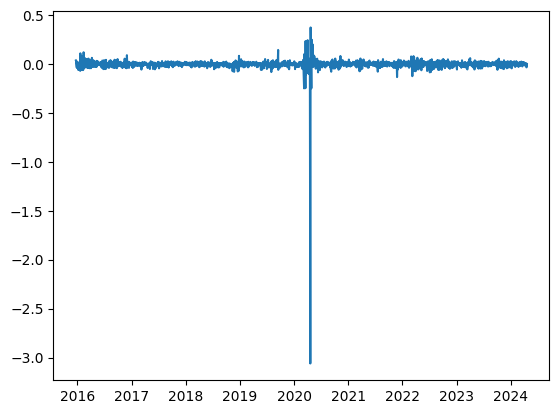

In [48]:
plt.plot(returns)

<Axes: >

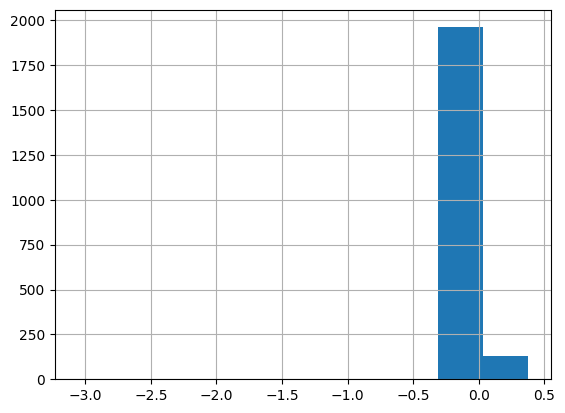

In [49]:
returns.hist()

In [50]:
# Flatten this matrix down.
npa = returns.values[1:].reshape(-1,1)
print(len(npa))
# # Let's scale the data -- this helps avoid the exploding gradient issue
scale = MinMaxScaler(feature_range=(0,1)) # This is by default.
npa = scale.fit_transform(npa)
print(len(npa))

2094
2094


In [51]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 13 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(npa.shape[0] - samples):
    X.append(npa[i:i+samples]) # Independent Samples
    Y.append(npa[i+samples][0]) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  13 :  [array([[0.90212566],
       [0.90134929],
       [0.89505426],
       [0.88054494],
       [0.8987782 ],
       [0.88063876],
       [0.89389661],
       [0.88819819],
       [0.88414404],
       [0.87421726],
       [0.88440136],
       [0.88943591],
       [0.87504009]])]
Testing Data: Length is  1 :  [0.8814110868235591]


In [52]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

threshold = round(0.9 * X.shape[0])
print('Threshold is', threshold)

Dimensions of X (2081, 13, 1) Dimensions of Y (2081,)
Threshold is 1873



Model1 With
3 RNNs layers 
1 Dense Layer 
Droupout Rete 0.2

In [53]:
# Let's build the RNN
model1 = keras.Sequential()

# Add a RNN layer with 3 units.
model1.add(layers.SimpleRNN(3,
                           activation = 'tanh',
                           use_bias=True,
                           input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model1.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model1.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model1.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model1.summary()

C:\Users\srava\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_20 (SimpleRNN)       │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (76.00 B)

 Trainable params: 19 (76.00 B)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Fitting the data
history1 = model1.fit(X[:threshold],
                    Y[:threshold],
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/100


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0800 - val_loss: 0.6471
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5288 - val_loss: 0.2122
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1859 - val_loss: 0.0455
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0747 - val_loss: 0.0168
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0684 - val_loss: 0.0105
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0746 - val_loss: 0.0068
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0626 - val_loss: 0.0060
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0643 - val_loss: 0.0059
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0621 - val_loss: 0.0043
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0560 - val_loss: 0.0057
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0561 - val_loss: 0.0052
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0578 - val_lo

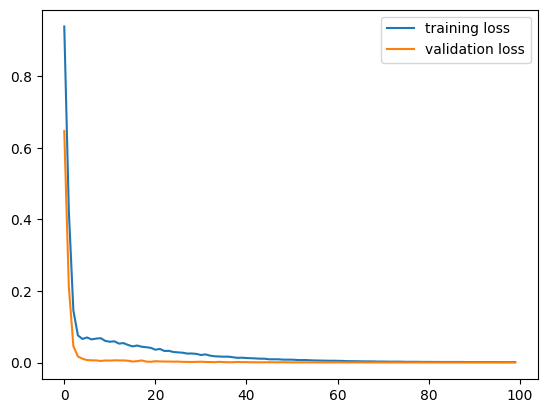

In [55]:
# Plotting the loss iteration
plt.plot(history1.history['loss'], label = 'training loss')
plt.plot(history1.history['val_loss'], label ='validation loss')
plt.legend()


In [56]:


# Evaluate the model on the test set
test_loss = model1.evaluate(X, Y)

# Print the test loss
print("Test Loss:", test_loss)

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions on the test set
y_pred1 = model1.predict(X)

# Calculate metrics
mae = mean_absolute_error(Y, y_pred1)
mse = mean_squared_error(Y, y_pred1)
rmse = np.sqrt(mse)

# Print the metrics
print("MAE Model1:", mae)
print("MSE Model1::", mse)
print("RMSE Model1::", rmse)



66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 5.2027e-04
Test Loss: 0.0007184043643064797
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE Model1: 0.007595549237753427
MSE Model1:: 0.0007184042287663826
RMSE Model1:: 0.026803063794394524


Model2 With
6 RNNs layers 
1 Dense Layer 
Droupout Rete 0.3

In [57]:
model2 = keras.Sequential()

# Add a RNN layer with 6 units.
model2.add(layers.SimpleRNN(6,
                            activation='tanh',
                            use_bias=True,
                            input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer
model2.add(layers.Dropout(rate=0.3))  # Increased dropout rate

# Add a Dense layer with 1 unit
model2.add(layers.Dense(1))

# Compile the model with MSE loss and Adam optimizer
model2.compile(loss='mean_squared_error', optimizer='adam')


C:\Users\srava\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
# Fitting the data
history2 = model2.fit(X[:threshold],
                    Y[:threshold],
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8636 - val_loss: 0.5261
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9386 - val_loss: 0.1617
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6629 - val_loss: 0.0609
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3752 - val_loss: 0.0352
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1893 - val_loss: 0.0123
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1144 - val_loss: 0.0083
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0711 - val_loss: 0.0033
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0571 - val_loss: 0.0044
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0496 - val_loss: 0.0043
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388 - val_loss: 0.0041
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0394 - val_loss: 0.0023
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

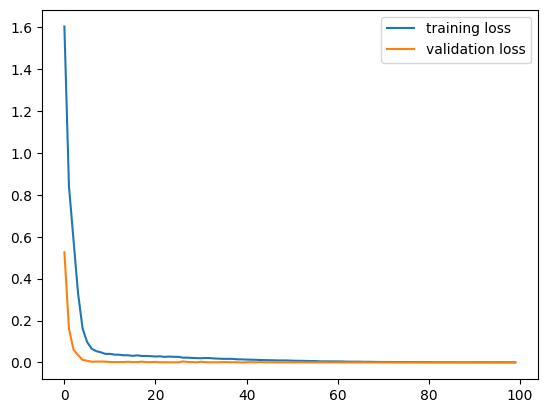

In [59]:
# Plotting the loss iteration
plt.plot(history2.history['loss'], label = 'training loss')
plt.plot(history2.history['val_loss'], label ='validation loss')
plt.legend()


In [61]:
# Evaluate the model on the test set
test_loss_model2 = model2.evaluate(X, Y)

# Print the test loss for model2
print("Test Loss Model2:", test_loss_model2)

# Make predictions on the test set for model2
y_pred2 = model2.predict(X)

# Calculate metrics for model2
mae_model2 = mean_absolute_error(Y, y_pred2)
mse_model2 = mean_squared_error(Y, y_pred2)
rmse_model2 = np.sqrt(mse_model2)

# Print the metrics for model2
print("MAE Model2:", mae_model2)
print("MSE Model2:", mse_model2)
print("RMSE Model2:", rmse_model2)


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 3.6671e-04
Test Loss Model2: 0.0004918909980915487
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE Model2: 0.00710711464497425
MSE Model2: 0.0004918910780917701
RMSE Model2: 0.022178617587482095


Model3 With
6 RNNs layers 
2 Dense Layer 
Droupout Rete 0.3

With 2 Dense Layers the batch size is not so flexible

I tried with multiple batch sizes for this combo from 1 to 32 only 3 is possible

Epoch 1/100


C:\Users\srava\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1800 - val_loss: 0.0147
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1265 - val_loss: 0.0116
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0966 - val_loss: 0.0058
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0729 - val_loss: 0.0066
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0714 - val_loss: 0.0070
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0575 - val_loss: 0.0067
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0589 - val_loss: 0.0026
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0505 - val_loss: 0.0045
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0414 - val_loss: 0.0037
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0376 - val_loss: 0.0027
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326 - val_loss: 0.0021
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296 - val_lo

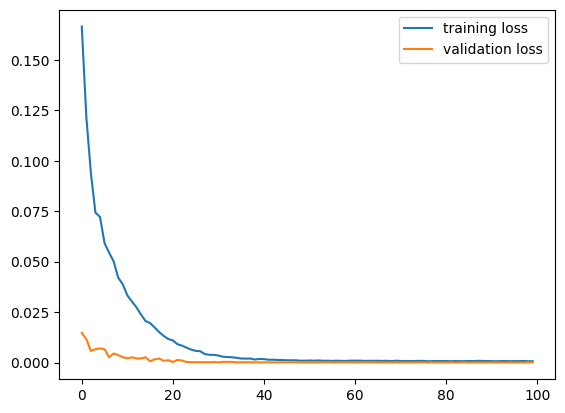

In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define model3
model3 = keras.Sequential()

# Add a RNN layer with 6 units and input shape matching the shape of X
model3.add(layers.SimpleRNN(6,
                             activation='tanh',
                             use_bias=True,
                             input_shape=(X.shape[1], X.shape[2])))  

# Add a dropout layer
model3.add(layers.Dropout(rate=0.4))  # Increased dropout rate

# Add a Dense layer with 1 unit
model3.add(layers.Dense(1))

# Compile the model with MSE loss and Adam optimizer
model3.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the data
history3 = model3.fit(X[:threshold],
                      Y[:threshold],
                      shuffle=False,  # Since this is time series data
                      epochs=100,
                      batch_size=32,
                      validation_split=0.2,
                      verbose=1)  # Verbose outputs data

# Plotting the loss iteration
plt.plot(history3.history['loss'], label='training loss')
plt.plot(history3.history['val_loss'], label='validation loss')
plt.legend()

# Evaluate the model on the test set
test_loss_model3 = model3.evaluate(X, Y)
print("Test Loss Model3:", test_loss_model3)

# Make predictions on the test set for model3
y_pred3 = model3.predict(X)

# Calculate metrics for model3
mae_model3 = mean_absolute_error(Y, y_pred3)
mse_model3 = mean_squared_error(Y, y_pred3)
rmse_model3 = np.sqrt(mse_model3)

# Print the metrics for model3
print("MAE Model3:", mae_model3)
print("MSE Model3:", mse_model3)
print("RMSE Model3:", rmse_model3)


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


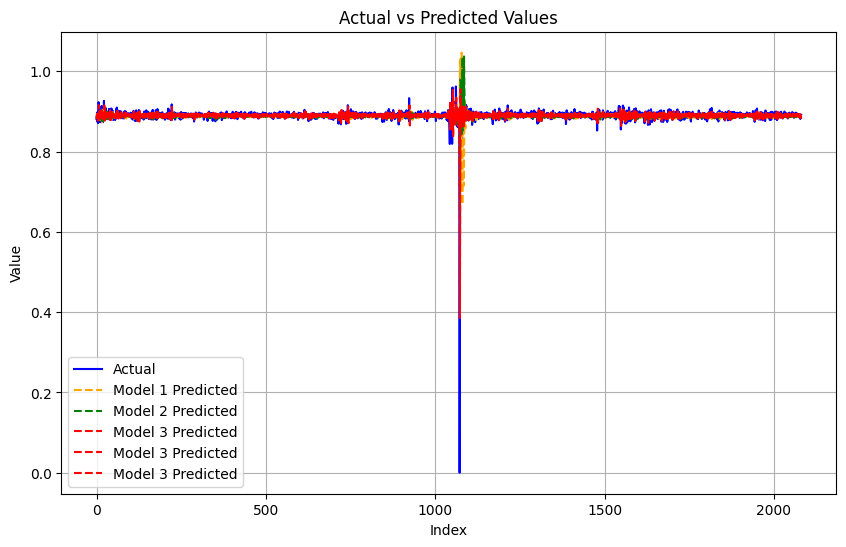

In [ ]:
import matplotlib.pyplot as plt

# Make predictions for all three models
y_pred1 = model1.predict(X)
y_pred2 = model2.predict(X)
y_pred3 = model3.predict(X)

# Plotting the actual vs predicted values for all three models
plt.figure(figsize=(10, 6))

# Model 1
plt.plot(Y, label='Actual', linestyle='-', color='blue')
plt.plot(y_pred1, label='Model 1 Predicted', linestyle='--', color='orange')

# Model 2
plt.plot(y_pred2, label='Model 2 Predicted', linestyle='--', color='green')

# Model 3
plt.plot(y_pred3, label='Model 3 Predicted', linestyle='--', color='red')

plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


Define Parameter Grid

In [ ]:
from itertools import product

# Define a dictionary to store parameter ranges
param_grid = {
    'layers.SimpleRNN units': [2, 4, 6, 8],  
    'layers.Dropout rate': [0.1, 0.2, 0.3, 0.4],  
}

# Create a list of all parameter combinations using product
all_params = list(product(*param_grid.values()))


Evaluation Function (Inner Loop):

In [ ]:
def evaluate_model(X, y, units, dropout_rate):
  # Create a new model instance for each parameter combination
  model = Sequential()
  model.add(layers.SimpleRNN(units, activation='tanh', use_bias=True, input_shape=(X.shape[1], X.shape[2])))
  model.add(layers.Dropout(rate=dropout_rate))
  model.add(layers.Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  # Fit the model with current parameters
  model.fit(X, y, epochs=10)  # Adjust epochs as needed

  # Evaluate and return performance metric (e.g., MSE)
  loss = model.evaluate(X, y)
  return loss


Looping and Evaluation (Outer Loop):

In [ ]:
best_params = None
best_loss = float('inf')  # Initialize with a high value

for params in all_params:
  units, dropout_rate = params  # Unpack parameter combination

  loss = evaluate_model(X, Y, units, dropout_rate)

  if loss < best_loss:  # Update best parameters and loss
    best_params = params
    best_loss = loss

print("Best parameters:", best_params)
print("Best loss:", best_loss)


Epoch 1/10


C:\Users\srava\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.3864  
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5121
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4902
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5504
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2252
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1153
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0762
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0546
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0418
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0367
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0071
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1846  
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1208
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0874
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0664
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s